In [8]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [9]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Dense, Concatenate

## Funciones auxiliares

In [11]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [12]:
df_test = pd.read_feather('test_normalized_data.fth')

- Para verificar que columnas tiene originalmente tests. Por ejemplo, como es de esperar, la columna customers no es dato y podría intentar estimarse tambien
- Es bastante discutible usar el clima y temperatura (Se puede usar el forecast si es en el futuro
- En un caso real no parece sensato usar google trend

In [13]:
df_test.columns

Index(['index', 'Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Promo2Since',
       'State', 'trend', 'trend_DE', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Mean_VisibilityKm', 'Precipitationmm',
       'CloudCover', 'Events', 'StateName', 'CompetitionDaysOpen',
       'CompetitionMonthsOpen', 'Promo2Days', 'Promo2Weeks',
       'StateHoliday_bool', 'Promo_y', 'StateHoliday_bool_y',
       'SchoolHoliday_y', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'AfterPromo',
       'BeforePromo', 'AfterSchoolHoliday_y', 'BeforeSchoolHoliday_y',
       'AfterStateHoliday_bool_y', 'BeforeStateHoliday_bool_y', 'AfterPromo_y',
       'BeforePromo_

In [14]:
df = pd.read_feather('train_normalized_data.fth')

In [15]:
df.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week',
       'Day', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Promo2Since',
       'State', 'trend', 'trend_DE', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Mean_VisibilityKm', 'Precipitationmm',
       'CloudCover', 'Events', 'StateName', 'CompetitionDaysOpen',
       'CompetitionMonthsOpen', 'Promo2Days', 'Promo2Weeks',
       'StateHoliday_bool', 'Promo_y', 'StateHoliday_bool_y',
       'SchoolHoliday_y', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'AfterPromo',
       'BeforePromo', 'AfterSchoolHoliday_y', 'BeforeSchoolHoliday_y',
       'AfterStateHoliday_bool_y', 'BeforeStateHoliday_bool_y', 'AfterPromo_y',
    

In [16]:
df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,0,1,2,3,4
DayOfWeek,4,4,4,4,4
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
Promo_bw,5,5,5,5,5
SchoolHoliday_bw,5,5,5,5,5
StateHoliday_bool_fw,0,0,0,0,0
Promo_fw,1,1,1,1,1


In [56]:
#Viejas

cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday',  'Promo2Weeks', 'Promo', 'SchoolHoliday', 'Open',
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw']

#min cat vars
cat_vars = ['Store','DayOfWeek']
#app1 catvars
cat_vars = ['Store','DayOfWeek', 'Promo_fw', 'Promo_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw']
#app2 catvars
cat_vars = ['Store','DayOfWeek', 'Promo_fw', 'Promo_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw','StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear']
#app3 catvars
cat_vars = ['Store','DayOfWeek','Promo_fw', 'Promo_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw',
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events']
#app4 catvars
cat_vars = ['Store','DayOfWeek', 'Year', 'Month', 'Day','SchoolHoliday', 'StateHoliday',
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events','Promo_fw', 'Promo_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw']

In [57]:
#Viejas
contin_vars = ['CompetitionDistance', 'CompetitionDaysOpen','CompetitionMonthsOpen',
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC','CloudCover', 'trend', 'trend_DE'
   ]


contin_vars = ['CompetitionDistance', 'Max_TemperatureC']
#full contin_vars
contin_vars = ['CompetitionDistance', 'CompetitionDaysOpen','CompetitionMonthsOpen',
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC','CloudCover', 'trend', 'trend_DE'
   ]

In [58]:
DataFrameSummary(df[cat_vars]).summary().loc[['uniques', 'types']]

,Store,DayOfWeek,Year,Month,Day,SchoolHoliday,StateHoliday,StoreType,Assortment,PromoInterval,...,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,SchoolHoliday_fw,SchoolHoliday_bw,StateHoliday_bool_fw,StateHoliday_bool_bw
uniques,1115,7,3,12,31,2,4,4,3,4,...,8,12,52,22,6,6,8,8,3,3
types,numeric,numeric,numeric,numeric,numeric,bool,numeric,numeric,numeric,numeric,...,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric


In [59]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [60]:
uniques

,Store,DayOfWeek,Year,Month,Day,SchoolHoliday,StateHoliday,StoreType,Assortment,PromoInterval,...,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,SchoolHoliday_fw,SchoolHoliday_bw,StateHoliday_bool_fw,StateHoliday_bool_bw
uniques,1115,7,3,12,31,2,4,4,3,4,...,8,12,52,22,6,6,8,8,3,3


In [61]:
uniques['DayOfWeek'][0]

7

# Asignación de dimensión de embeddings

In [62]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 4, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [63]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 2, 'Year': 2, 'Open': 2,'Month': 2, 'CloudCover': 2,
'Day': 10, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2, 'SchoolHoliday': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 25, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

## Ejemplo con DayOfWeek, store y CompetitionDistance

In [64]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 50 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 2 7 [0 1 2 3 4 5 6]

Year 2 3 [0 1 2]

Month 2 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Day 10 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

SchoolHoliday 2 2 [0 1]

StateHoliday 2 4 [0 1 2 3]

StoreType 2 4 [0 1 2 3]

Assortment 3 3 [0 1 2]

PromoInterval 3 4 [0 1 2 3]

CompetitionOpenSinceYear 4 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Promo2SinceYear 4 8 [0 1 2 3 4 5 6 7]

State 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Week 25 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]

Events 4 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]

Promo_fw 1 6 [0 1 2 3 4 5]

Promo_bw 1 6 [0 1 2 3 4 5]

SchoolHoliday_fw 1 8 [0 1 2 3 4 5 6 7]

SchoolHoliday_bw 1 8 [0 1 2 3 4 5 6 7]

StateHoliday_bool_fw 1 3 [0 1 2]

Stat

A mano

In [26]:
day_of_week_input = Input(shape=(1,), name="day_of_week_input")
store_input = Input(shape=(1,), name="store_input")
# Por ser continua competition_distance no necesita embeddings
competition_distance_input = Input(shape=(1,), name="competition_distance_input")

day_of_week_Embedd_out = Embedding(uniques['DayOfWeek'][0], cat_var_dict['DayOfWeek'], name="day_of_week_Embedd")(day_of_week_input)
store_Embedd_out = Embedding(uniques['Store'][0], cat_var_dict['Store'], name="store_Embedd")(store_input)

In [56]:
print(f'Entradas: {day_of_week_input.shape}, {store_input.shape}')
print(f'Salidas: {day_of_week_Embedd_out.shape}, {store_Embedd_out.shape}')

Entradas: (None, 1), (None, 1)
Salidas: (None, 1, 4), (None, 1, 50)


In [57]:
day_of_week_Embedd_flat = Flatten(name="day_of_week_flat")(day_of_week_Embedd_out)
store_Embedd_flat = Flatten(name="store_flat")(store_Embedd_out)

Con funciones

In [65]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [66]:
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)

In [67]:
x = Dense(1000, activation='relu')(merged)
x = Dense(500, activation='relu')(x)
output = Dense(1, activation='linear')(x)

In [68]:
model = Model(cat_var_inputs + cont_vars_inputs, output)

In [69]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Year_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Month_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                            

In [70]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]

In [71]:
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [72]:
df_train[['DayOfWeek', 'Store', 'CompetitionDistance']].values.shape

(814150, 3)

In [73]:
X_train = np.hsplit(df_train[['DayOfWeek', 'Store', 'CompetitionDistance']].values, 3)
X_val = np.hsplit(df_val[['DayOfWeek', 'Store', 'CompetitionDistance']].values, 3)

In [74]:
len(X_train[2])

814150

In [75]:
# Normalización
y_mean = df_train['Sales'].mean()
y_std = df_train['Sales'].std()

# Escala logaritmica
# max_log_y = np.max(np.log(df['Sales']))
# y_train = np.log(df['Sales'])/max_log_y

In [76]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [77]:
y_train = (df_train['Sales'].values - y_mean)/y_std
y_val = (df_val['Sales'].values - y_mean)/y_std

In [78]:
model.compile(optimizer=Adam(lr=0.001), metrics=['mse'], loss='mse')

C:\Users\germa\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [79]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=1, batch_size=256)

3181/3181 [==============================] - 171s 48ms/step - loss: 0.1086 - mse: 0.1086 - val_loss: 0.1344 - val_mse: 0.1344


# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [80]:
y_pred_norm = model.predict(X_val, verbose=1)
y_pred = y_pred_norm*y_std + y_mean
# y_pred = np.exp(model.predict(X_train)*max_log_y)

944/944 [==============================] - 14s 12ms/step


In [81]:
def root_mean_squared_error_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_pred - y_true)), axis=-1))

def rmspe_np(y_true, y_pred):
    MSEP_ = ((y_true - y_pred)/y_true)**2
    return np.sqrt(MSEP_.mean())

In [82]:
rmspe_np(df_val['Sales'].values, y_pred.reshape(-1))

0.14921874805450822

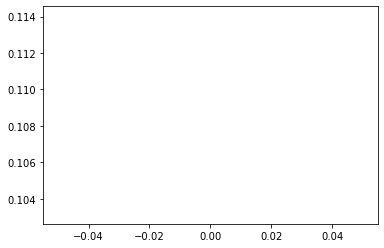

In [83]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.show()